In [1]:
import re
import pandas as pd
from wordcloud import WordCloud
import nltk
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
def clean(text):
    text = text.lower()
    text = re.sub(
        r"https?:\/\/(www\.)? ?[-a-zA-Z0-9@:%._\+~#=]{1,256}\. ?[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)",
        "",
        text,
    )
    text = re.sub(r"(it | he | she | that)'s", '\1 is', text)
    text = re.sub(r"(they | we | you)'re", '\1 are', text)
    text = re.sub(r"youre", 'you are', text)
    text = re.sub(r"(they | we | you)'ve", '\1 have', text)
    text = re.sub(r"this'", 'this is', text)
    text = re.sub(r"http", ' ', text)
    text = re.sub(r"i[']m", 'i am', text)
    text = re.sub(r"didn[']t", 'did not', text)
    text = re.sub(r"don[']t", 'do not', text)
    text = re.sub(r"don[']t", 'do not', text)
    text = re.sub(r"can't", 'cannot', text)
    text = re.sub(r"&.+;", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [3]:
df = pd.read_csv('irony-labeled.csv')

In [4]:
df['comment_text'] = df['comment_text'].apply(clean)

In [5]:
df.tail(3)

,comment_text,label
1946,[... what? ](,-1
1947,does anybody remember during one of the debate...,-1
1948,the pope is meeting a cruel dictator. likely w...,1


In [6]:
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['im', 'sourcehttpwww'])
STOPWORDS = set(STOPWORDS)

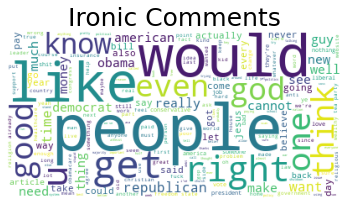

In [7]:
text_ironic = ' '.join(df.comment_text[df['label'] == 1])
wc_ironic = WordCloud(background_color='white',stopwords=STOPWORDS).generate(text_ironic)
plt.imshow(wc_ironic)
plt.axis('off')
plt.title('Ironic Comments',fontsize=25)
plt.show()

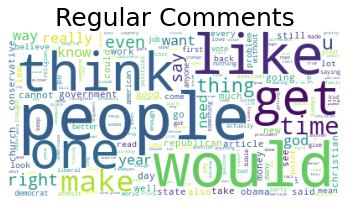

In [8]:
text = ' '.join(df.comment_text[df['label'] == -1])
wc = WordCloud(background_color='white',stopwords=STOPWORDS).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.title('Regular Comments',fontsize=25)
plt.show()

In [9]:
def preprocess(sent):
    def convert(word):
        word = re.sub(r"\W+", "", word)
        # Verifica se é um número.
        try:
            _ = float(word)
            return '<num>'
        except:
            pass

        # Verifica se é uma palavra.
        if word.isalpha():
            lower = word.lower()
            return '<stop>' if lower in STOPWORDS else lower

        # Caso contrário, é pontuação ou estranho.
        return '<weird>'

    processed = [convert(word) for word in sent]
    forbidden_words = set(('<num>', '<stop>', '<weird>'))
    return [word for word in processed if word not in forbidden_words]

In [10]:
sents_all = [preprocess(item.strip().split()) for item in df.comment_text]
df['word_list'] = sents_all
df.head(3)

,comment_text,label,word_list
0,i suspect atheists are projecting their desire...,-1,"[suspect, atheists, projecting, desires, imagi..."
1,it's funny how the arguments the shills are ma...,-1,"[funny, arguments, shills, making, still, clos..."
2,we are truly following the patterns of how the...,-1,"[truly, following, patterns, mandarins, took, ..."


In [11]:
from collections import defaultdict
word_counts_ironic = defaultdict(lambda: 0)
word_counts_non_ironic = defaultdict(lambda: 0)

for i in range(len(df)):
    if df['label'][i] == 1:
        for j in df['word_list'][i]:
            word_counts_ironic[j] += 1 
    else:
        for j in df['word_list'][i]:
            word_counts_non_ironic[j] += 1
    
word_counts_ironic_sorted = sorted(word_counts_ironic.items(), key=lambda k: k[1], reverse=True)
word_counts_non_ironic_sorted = sorted(word_counts_non_ironic.items(), key=lambda k: k[1], reverse=True)

print("Most common words in ironic texts")
r = 30
k = 10
for i in range(k):
    print(word_counts_ironic_sorted[i+r])
print("=" * 80)
print("Most common words in non ironic texts")
for i in range(k):
    print(word_counts_non_ironic_sorted[i+r])

Most common words in ironic texts
('bill', 18)
('said', 18)
('doesnt', 18)
('every', 18)
('thing', 18)
('got', 17)
('american', 17)
('take', 17)
('pay', 17)
('republicans', 17)
Most common words in non ironic texts
('party', 77)
('years', 77)
('things', 73)
('still', 71)
('isnt', 71)
('need', 70)
('go', 69)
('church', 68)
('work', 67)
('many', 67)


### LDA

In [12]:
from gensim.corpora import Dictionary
import gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

c:\users\mathe\appdata\local\programs\python\python38\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [13]:
#Generate LDA MODEL
from gensim.models.ldamulticore import LdaMulticore, LdaModel
def model_dict(sents, NUM_TOPICS):
    dictionary = Dictionary(sents)
    corpus = [dictionary.doc2bow(sent) for sent in sents]

    ldamodel = LdaMulticore(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=30, random_state=42)

    return corpus, dictionary, ldamodel

In [14]:
#Check topics

def check_topics(corpus, lda_model):
    topics = lda_model.get_document_topics(corpus, per_word_topics=True)


    doc_topics, word_topics, phi_values = topics[10]
    print('Document topic:', doc_topics, "\n")

    for topic, strength in doc_topics:
        print(f'Topico: {topic}')
        print(lda_model.print_topic(topic, topn=20))

    topics = lda_model.print_topics(num_words=10)
    for topic in topics:
        print(topic)

In [15]:
def display_model(corpus, dictionary, ldamodel):  
    lda_display = pyLDAvis.gensim_models.prepare(
        ldamodel,
        corpus,
        dictionary,
        sort_topics=False,
    )
    return pyLDAvis.display(lda_display)

In [16]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    # adaptado de https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus = corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
limit=10
start=2 
step=1
dictionary_all = Dictionary(sents_all)
corpus_all = [dictionary_all.doc2bow(sent) for sent in sents_all]
model_list, coherence_values = compute_coherence_values(dictionary_all, corpus_all, sents_all, limit, start, step)

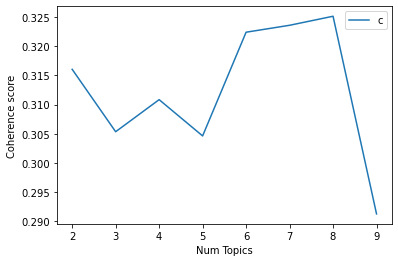

In [18]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
corpus_all, dictionary_all, lda_model_all = model_dict(sents_all, NUM_TOPICS=8)
# check_topics(corpus_all, lda_model_all)

In [20]:
display_model(corpus_all, dictionary_all, lda_model_all)

In [21]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
#Dominant topic in each sentence
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(lda_model_all, corpus_all, sents_all)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic['label'] = df['label']
df_dominant_topic['check'] = df['word_list'] == df_dominant_topic['Text']

df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,label,check
0,0,5.0,0.9742,"people, really, get, like, want, would, one, v...","[suspect, atheists, projecting, desires, imagi...",-1,True
1,1,4.0,0.9796,"people, like, would, also, said, make, right, ...","[funny, arguments, shills, making, still, clos...",-1,True
2,2,6.0,0.7336,"like, get, people, money, would, government, d...","[truly, following, patterns, mandarins, took, ...",-1,True
3,3,7.0,0.9650,"god, like, good, even, people, would, us, righ...","[air, pressure, dropping, altitude, goes, high...",-1,True
4,4,2.0,0.9602,"would, people, even, us, think, sure, like, kn...","[absolutely, think, wed, hard, pressed, find, ...",-1,True


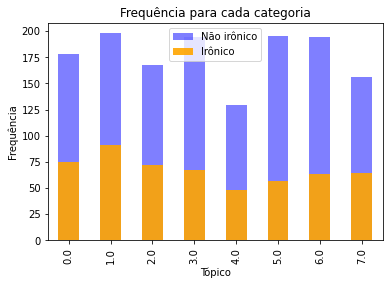

In [22]:
ironic = df_dominant_topic[df_dominant_topic['label'] == 1]
nonIronic = df_dominant_topic[df_dominant_topic['label'] == -1]

fig, ax = plt.subplots()
nonIronic['Dominant_Topic'].value_counts().sort_index().plot(kind='bar', color='b', label='Não irônico', alpha=0.5)
ironic['Dominant_Topic'].value_counts().sort_index().plot(kind='bar', color='orange', label='Irônico', alpha=0.9)
plt.ylabel('Frequência')
plt.xlabel('Tópico')
plt.legend()
plt.title("Frequência para cada categoria")
plt.show()

In [23]:
countNonIronic = nonIronic['Dominant_Topic'].value_counts().sort_index()
countIronic = ironic['Dominant_Topic'].value_counts().sort_index()

ironicPercentage = countIronic/(countIronic + countNonIronic) * 100
print("Porcentagem de documentoes irônicos por tópico:")
for i in range(len(ironicPercentage)):
    print(f"Tópico {i}: {ironicPercentage[i]:.2f}%")

Porcentagem de documentoes irônicos por tópico:
Tópico 0: 29.64%
Tópico 1: 31.49%
Tópico 2: 30.00%
Tópico 3: 25.67%
Tópico 4: 27.12%
Tópico 5: 22.62%
Tópico 6: 24.51%
Tópico 7: 29.09%


In [24]:
#Dominant topics occurences
df_dominant_topic.Dominant_Topic.value_counts()

#Dominant topic with most occurences
dominant_topic = df_dominant_topic.Dominant_Topic.value_counts().index[0]

#Documents related to dominant topic with most occurences
df_dominant_topic[df_dominant_topic.Dominant_Topic == dominant_topic].head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,label,check
7,7,1.0,0.7080,"would, one, like, get, think, party, people, t...","[would, win]",-1,True
9,9,1.0,0.7951,"would, one, like, get, think, party, people, t...","[insane, like, fox, ted, cruz, actually, intel...",1,True
20,20,1.0,0.9513,"would, one, like, get, think, party, people, t...","[makes, cringe, sure, use, memes, try, appeal,...",1,True


In [25]:
#Most representative document for each topic
representativeDoc = pd.DataFrame()

groupByDominantTopic = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in groupByDominantTopic:
    representativeDoc = pd.concat([representativeDoc, 
                        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                        axis=0)

# Reset Index    
representativeDoc.reset_index(drop=True, inplace=True)

# Format
representativeDoc.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
representativeDoc

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9962,"know, would, like, could, said, people, party,...","[much, purported, left, seems, stuck, tedious,..."
1,1.0,0.9958,"would, one, like, get, think, party, people, t...","[one, example, patient, suffering, sleep, apne..."
2,2.0,0.9940,"would, people, even, us, think, sure, like, kn...","[holy, bible, never, condoned, homosexual, mar..."
3,3.0,0.9934,"think, would, people, like, one, right, really...","[spent, hours, stopped, traffic, routes, miles..."
4,4.0,0.9974,"people, like, would, also, said, make, right, ...","[infuriates, people, reddit, use, tired, old, ..."
5,5.0,0.9933,"people, really, get, like, want, would, one, v...","[probably, going, buried, need, say, piece, se..."
6,6.0,0.9970,"like, get, people, money, would, government, d...","[sick, tired, whole, media, cabal, bullshit, e..."
7,7.0,0.9946,"god, like, good, even, people, would, us, righ...","[pathetic, many, levels, imagine, subconscious..."


In [26]:
for i in range(len(representativeDoc)):
    print(f"Topic {i}\n", " ".join(representativeDoc["Text"][i]))
    print('=' * 80)

Topic 0
 much purported left seems stuck tedious oppositionalist rut rhetorically weaseling narrow sectarian splinter vanguard hegemony real left call electoral boycott us going century nobodys perfect every regard without going substance purported left critique brand analysis substantially incorrect despite somewhat correct less critique capitalism main claim fame democracy know correct many regards simply politically incorrect advocate electoral boycott analysis purported left position tend believe better extreme right prevail electorally based theory draconian conditions guaranteed ensue ultimately goad masses rising overthrow capitalism altogether voting bourgeois reformists say serve lull masses sleep thinking good thus preserving capitalism rationale gave us hitler nixon reagan bushs failed produce revolution anywhere indeed ushered moar draconian rightwing antidemocratic counterrevolutionary policies ruining lives millions people world suppressing revolutionary popular democrati